# Qubit sensing protocols
## GHZ example
This example shows a qubit GHZ experiment, which staturates the Heisenberg limit.

In [1]:
import itertools

import equinox as eqx
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns
from rich.pretty import pprint

from squint.circuit import Circuit
from squint.ops.base import SharedGate
from squint.ops.dv import Conditional, DiscreteState, HGate, Phase, XGate

In [7]:
n = 4
circuit = Circuit()
for i in range(n):
    circuit.add(DiscreteState(wires=(i,), n=(0,)))

circuit.add(HGate(wires=(0,)))
for i in range(n - 1):
    circuit.add(Conditional(gate=XGate, wires=(i, i + 1)))

circuit.add(
    SharedGate(op=Phase(wires=(0,), phi=0.1 * jnp.pi), wires=tuple(range(1, n))),
    "phase",
)

for i in range(n):
    circuit.add(HGate(wires=(i,)))

params, static = eqx.partition(circuit, eqx.is_inexact_array)

pprint(params)

Circuit(
  ops={
│   0:
│   DiscreteState(wires=(None,), n=[(None, (None,))]),
│   1:
│   DiscreteState(wires=(None,), n=[(None, (None,))]),
│   2:
│   DiscreteState(wires=(None,), n=[(None, (None,))]),
│   3:
│   DiscreteState(wires=(None,), n=[(None, (None,))]),
│   4:
│   HGate(wires=(None,)),
│   5:
│   Conditional(wires=(None, None), gate=XGate(wires=(None,))),
│   6:
│   Conditional(wires=(None, None), gate=XGate(wires=(None,))),
│   7:
│   Conditional(wires=(None, None), gate=XGate(wires=(None,))),
│   'phase':
│   SharedGate(
│     wires=(None, None, None, None),
│     op=Phase(wires=(None,), phi=weak_f32[]),
│     copies=[
│   │   Phase(wires=(None,), phi=None),
│   │   Phase(wires=(None,), phi=None),
│   │   Phase(wires=(None,), phi=None)
│     ],
│     where=None,
│     get=None
│   ),
│   9:
│   HGate(wires=(None,)),
│   10:
│   HGate(wires=(None,)),
│   11:
│   HGate(wires=(None,)),
│   12:
│   HGate(wires=(None,))
  }
)

2025-03-05 22:35:10.275 | INFO     | squint.circuit:compile:114 -   Complete contraction:  a,b,c,d,ae,efbg,ghci,ijdk,fl,hm,jn,ko,lp,mq,nr,os->pqrs
         Naive scaling:  19
     Optimized scaling:  5
      Naive FLOP count:  8.389e+6
  Optimized FLOP count:  3.920e+2
   Theoretical speedup:  2.140e+4
  Largest intermediate:  1.600e+1 elements
--------------------------------------------------------------------------------
scaling        BLAS                current                             remaining
--------------------------------------------------------------------------------
   4    GEMV/EINSUM            efbg,b->efg    a,c,d,ae,ghci,ijdk,fl,hm,jn,ko,lp,mq,nr,os,efg->pqrs
   4    GEMV/EINSUM            ghci,c->ghi    a,d,ae,ijdk,fl,hm,jn,ko,lp,mq,nr,os,efg,ghi->pqrs
   4    GEMV/EINSUM            ijdk,d->ijk    a,ae,fl,hm,jn,ko,lp,mq,nr,os,efg,ghi,ijk->pqrs
   2           GEMM                ae,a->e    fl,hm,jn,ko,lp,mq,nr,os,efg,ghi,ijk,e->pqrs
   3           GEMM             

[Text(0.5, 0, 'Phase, $\\varphi$'), Text(0, 0.5, '$\\mathcal{I}_\\varphi^C$')]

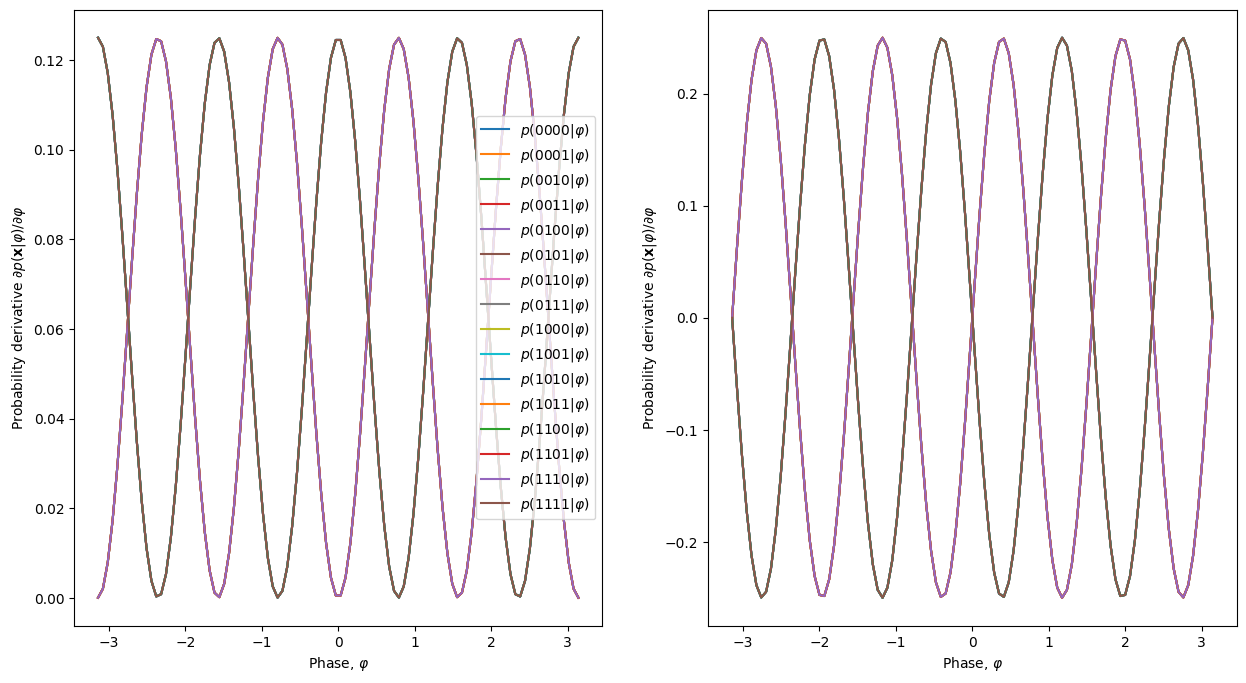

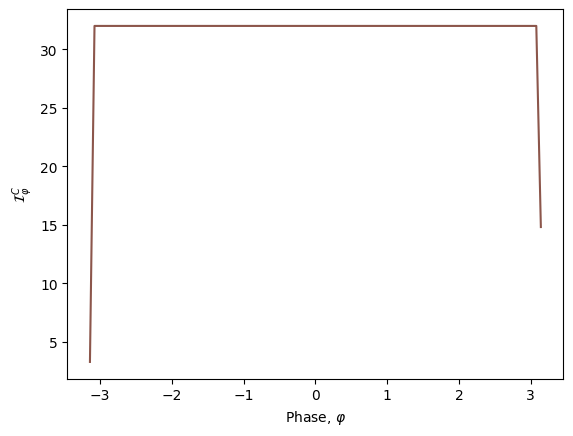

In [31]:
sim = circuit.compile(params, static, dim=2, optimize="greedy")

get = lambda pytree: jnp.array([pytree.ops["phase"].op.phi])

phis = jnp.linspace(-jnp.pi, jnp.pi, 100)
params = eqx.tree_at(
    lambda pytree: pytree.ops["phase"].op.phi, params, jnp.expand_dims(phis, axis=1)
)

probs = eqx.filter_vmap(sim.prob.forward)(params)
grads = get(eqx.filter_vmap(sim.prob.grad)(params)).squeeze()
cfims = eqx.filter_vmap(sim.prob.cfim, in_axes=(None, 0))(get, params)

colors = sns.color_palette(n_colors=jnp.prod(jnp.array(probs.shape[1:])))
fig, axs = plt.subplots(ncols=2, figsize=[15, 8])
for i, idx in enumerate(
    itertools.product(*[list(range(ell)) for ell in probs.shape[1:]])
):
    axs[0].plot(
        phis,
        probs[:, *idx],
        label=f"$p({''.join(map(str, idx))}" + r"|\varphi)$",
        color=colors[i],
    )
    axs[1].plot(
        phis,
        grads[:, *idx],
        label=r"$\partial"
        + f"p({''.join(map(str, idx))}"
        + r"|\varphi) / \partial \varphi$",
        color=colors[i],
    )

axs[0].legend()
for ax in axs:
    ax.set(
        xlabel=r"Phase, $\varphi$",
        ylabel=r"Probability derivative $\partial p(\mathbf{x} | \varphi) / \partial \varphi$",
    )


fig, ax = plt.subplots()
ax.plot(phis, cfims.squeeze(), color=colors[i])
ax.set(xlabel=r"Phase, $\varphi$", ylabel=r"$\mathcal{I}_\varphi^C$")